In [1]:
include("../ToolBox/ToolBox.jl")
using .ToolBox
import JLD
using Colors
import FileIO
import PyPlot

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1273
  likely near /home/simon/.julia/packages/Images/RUVAg/src/Images.jl:60
┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


In [2]:
function db_scale_img(img , min , max)
    log_img = (10*log10.(img).-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end


function db_scale_img_diff(img1,img2 , min , max)
    log_img = 10*log10.(img1).-10*log10.(img2)
    log_img = (log_img.-min)./(max-min)
    log_img[log_img.>1] .= 0.999
    log_img[log_img.<0] .= 0.001
    return log_img
end

function scale_img(img , min , max)
    scale_img = (img.-min)./(max-min)
    scale_img[scale_img.>1] .= 0.999
    scale_img[scale_img.<0] .= 0.001
    return scale_img
end


function scale_img(img)
    min = minimum(reshape(img,:))
    max = maximum(reshape(img,:))
    return scale_img(img , min , max)
end

min_vv = -19
max_vv = 4

min_vh = -26
max_vh = -3

min_r = -10
max_r = 1;

min_h = -10
max_h = 100;

flat(band,test_area) = reshape(band[test_area...],:)

function scale_xticks(fig,ax,factor)
    fig.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels = [replace(item, '−' => '-') for item in labels]
    labels = [parse(Float64,item) for item in labels]
    labels = labels.*factor
    labels = [string(item) for item in labels]
    ax.set_xticklabels(labels)
end

function pretty_img(bands,min,max,k=1/1.4)
    pre = db_scale_img((bands[2] .+bands[3])./2,min,max) 
    co = db_scale_img(bands[1],min,max) 
    co = co.^k
    pre = pre.^k
    return Colors.RGB{Float32}.(pre,co,co);
end



function grid_images(img_array,pad =2)
    
    v_pad = zeros(RGB{Float32},pad,size(img_array[1,1])[2])
    grid_img = [vcat(elem,v_pad) for elem in img_array]
    
    grid_img = [vcat(grid_img[:,i]...) for i in 1:size(img_array)[2]]
    
    h_pad = zeros(RGB{Float32},size(grid_img[1])[1],pad)
    grid_img = [hcat(elem,h_pad) for elem in grid_img]
    
    grid_img = hcat(grid_img...)

    return grid_img[1:end-pad,1:end-pad]
end


grid_images (generic function with 2 methods)

In [104]:
folder = "/home/data/simon/processed/66_fyn_winter2020/vejle" # desend

dem_nan = 40

co_gamma = JLD.load(joinpath(folder,"21VV_coher.jld"),"data")[:,end:-1:1]
pre_gamma = JLD.load(joinpath(folder,"23VV_coher.jld"),"data")[:,end:-1:1]

VV_paths = [joinpath(folder,string(i)*"VV_itens.jld") for i=1:3]
VV = [JLD.load(path,"data")[:,end:-1:1] for path in VV_paths]
VH_paths = [joinpath(folder,string(i)*"VH_itens.jld") for i=1:3]
VH = [JLD.load(path,"data")[:,end:-1:1] for path in VH_paths];
heights = JLD.load(joinpath(folder,"heights.jld"),"data")[:,end:-1:1].-dem_nan;

In [105]:
#### 

VV_org = deepcopy(VV)
VH_org = deepcopy(VH)

filt = SlcUtil.temporal_filter([VV[1],VH[1]],5);

VV = SlcUtil.temporal_filter(VV,5);
VH = SlcUtil.temporal_filter(VH,5);

VV[1] = filt[1]
VH[1] = filt[2];

In [115]:
size(VV[1])

(709, 1425)

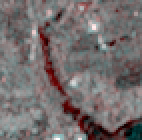

In [128]:
#test_area = (220:240,80:140) ; folder = "/home/data/simon/result/explore/area_1"
test_area = (640:709,880:950) ; folder = "/home/data/simon/result/explore/area_2"
pretty_img(VV,min_vv,max_vv)[test_area...]

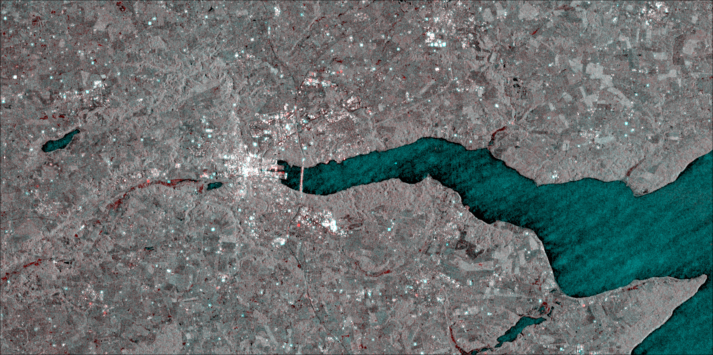

In [129]:
pretty_img(VV,min_vv,max_vv)

In [31]:
import StatsBase;
import LsqFit
import Statistics

In [130]:


LsqFit.@. bimodal_gauss_model(x, p) = p[1]*exp(-0.5*((x-p[3])/p[5])^2) +  p[2]*exp(-0.5*((x-p[4])/p[6])^2)

function fit_bimodal_gauss(data,n_bins,maxIter=1000)
    h = StatsBase.fit(StatsBase.Histogram, data,nbins=n_bins)
    w = h.weights
    y = (collect(h.edges[1])[2:end] +  collect(h.edges[1])[1:end-1])/2;
    
    p0 = zeros(Float64,6)
    y_ot = Statistics.median(data)

    p0[3] = Statistics.mean(data[data.<y_ot])
    p0[5] = Statistics.std(data[data.<y_ot])
    p0[1] = w[findfirst(y.>p0[3])]


    p0[4] = Statistics.mean(data[data.>y_ot])
    p0[6] = Statistics.std(data[data.>y_ot])
    p0[2] = w[findfirst(y.>p0[4])];
    p_fit = LsqFit.curve_fit(bimodal_gauss_model, y, w, p0; autodiff=:forwarddiff,maxIter=1000).param
    
    return p_fit, y, w

end
    
    

fit_bimodal_gauss (generic function with 2 methods)

In [142]:
data = 10 .* log10.(flat(VH[1],test_area));

In [143]:
data

4970-element Array{Float64,1}:
 -18.492122457670387
 -18.15100216081174 
 -16.148886776512676
 -15.769901698686336
 -16.964292203717896
 -18.038506383358566
 -18.3064512387859  
 -17.45065471483915 
 -17.41860252719836 
 -17.191171730034903
 -17.86001165716304 
 -18.405937255941243
 -17.27619339821047 
   ⋮                
 -19.712016501073855
 -22.664257764297414
 -23.002159725130262
 -23.356204060530565
 -25.084155309961314
 -26.40461659143171 
 -26.629638874840186
 -27.839672354673347
 -28.526975090065708
 -28.29751462181258 
 -28.11714705536362 
 -27.906016162136883

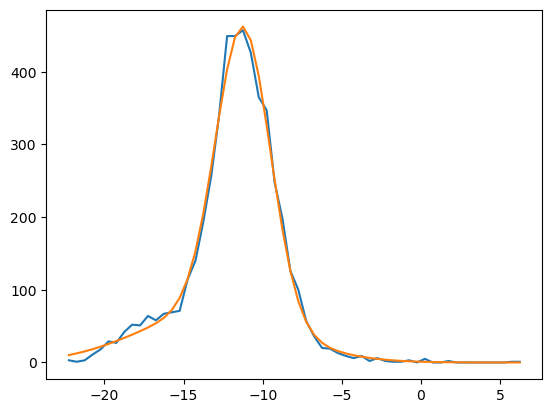

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fc9d709f6a0>

In [141]:

p_fit,y,w = fit_bimodal_gauss(data,round(Int64,length(data)/50),10000)

PyPlot.figure()
PyPlot.plot(y,w)
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )

In [56]:
import Pkg
Pkg.add("LsqFit")

 Resolving package versions...
 Installed QuadGK ───────── v2.3.1
 Installed StatsFuns ────── v0.9.4
 Installed NLSolversBase ── v7.6.1
 Installed Arpack ───────── v0.4.0
 Installed FiniteDiff ───── v2.3.0
 Installed OptimBase ────── v2.0.0
 Installed LsqFit ───────── v0.10.0
 Installed Rmath ────────── v0.6.1
 Installed OpenBLAS_jll ─── v0.3.9+0
 Installed FillArrays ───── v0.8.6
 Installed PDMats ───────── v0.9.12
 Installed Arpack_jll ───── v3.5.0+2
 Installed Rmath_jll ────── v0.2.2+0
 Installed ArrayInterface ─ v2.6.2
 Installed Distributions ── v0.22.6
  Updating `~/.julia/environments/v1.3/Project.toml`
  [2fda8390] + LsqFit v0.10.0
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [7d9fca2a] + Arpack v0.4.0
  [68821587] + Arpack_jll v3.5.0+2
  [4fba245c] + ArrayInterface v2.6.2
  [31c24e10] + Distributions v0.22.6
  [1a297f60] + FillArrays v0.8.6
  [6a86dc24] + FiniteDiff v2.3.0
  [2fda8390] + LsqFit v0.10.0
  [d41bc354] + NLSolversBase v7.6.1
  [4536629a] + OpenBLAS_jll 

In [69]:
import StatsBase;
using BenchmarkTools
import PyCall
import LsqFit
import Statistics

In [11]:
test_data = flat(band1[1],test_area);

In [37]:
@benchmark h = StatsBase.fit(StatsBase.Histogram, test_data, nbins=round(Int64,length(test_data)/100))

BenchmarkTools.Trial: 
  memory estimate:  2.59 KiB
  allocs estimate:  7
  --------------
  minimum time:     2.255 ms (0.00% GC)
  median time:      2.274 ms (0.00% GC)
  mean time:        2.287 ms (0.00% GC)
  maximum time:     2.370 ms (0.00% GC)
  --------------
  samples:          2185
  evals/sample:     1

In [40]:
np = PyCall.pyimport("numpy")

PyObject <module 'numpy' from '/home/data/simon/anaconda3/envs/sentinel/lib/python3.8/site-packages/numpy/__init__.py'>

In [41]:
@benchmark h = np.histogram(test_data, bins=round(Int64,length(test_data)/100))

BenchmarkTools.Trial: 
  memory estimate:  13.77 KiB
  allocs estimate:  140
  --------------
  minimum time:     682.333 μs (0.00% GC)
  median time:      698.416 μs (0.00% GC)
  mean time:        703.403 μs (0.00% GC)
  maximum time:     2.689 ms (0.00% GC)
  --------------
  samples:          7056
  evals/sample:     1

In [70]:
w,y = np.histogram(test_data, bins=round(Int64,length(test_data)/200),normed=true)
y = (y[2:end] +  y[1:end-1])/2;

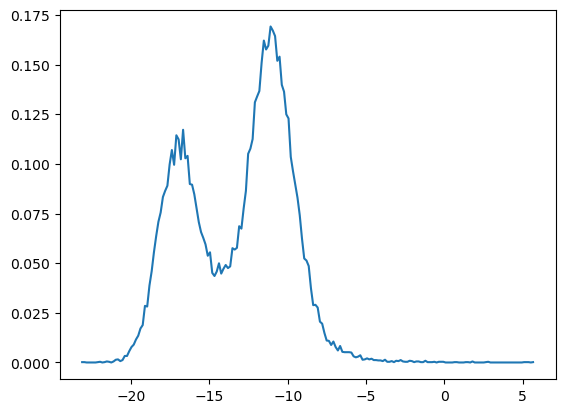

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd8aebe66a0>

In [71]:
PyPlot.figure()
PyPlot.plot(y,w)

In [157]:
h = StatsBase.fit(StatsBase.Histogram, test_data, nbins=round(Int64,length(test_data)/100))

w = h.weights
y= (collect(h.edges[1])[2:end] +  collect(h.edges[1])[1:end-1])/2;

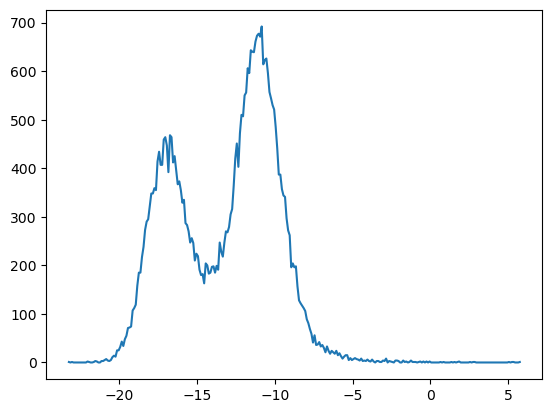

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd8aea642e0>

In [158]:
PyPlot.figure()
PyPlot.plot(y,w)

In [182]:
p0 = zeros(Float64,6)
y_ot = Statistics.median(test_data)

p0[2] = Statistics.mean(test_data[test_data.<y_ot])
p0[3] = Statistics.std(test_data[test_data.<y_ot])
p0[1] = w[findfirst(y.>p0[2])]


p0[5] = Statistics.mean(test_data[test_data.>y_ot])
p0[6] = Statistics.std(test_data[test_data.>y_ot])
p0[4] = w[findfirst(y.>p0[5])];

In [183]:
p[1:3]

3-element Array{Float64,1}:
  932.0              
 1363.0              
  -16.776423251837937

In [184]:
p_fit = LsqFit.curve_fit(bi_gauss_model, y, w, p0; autodiff=:forwarddiff,maxIter=1000).param

6-element Array{Float64,1}:
 436.6744179567643   
 -16.869280438570836 
   1.4107828066777353
 646.1444668500477   
 -11.099373442207835 
   1.5155973090004635

In [185]:
p_fit.resid

ErrorException: type Array has no field resid

In [186]:
bimodal_gauss_model(y, p_fit)

291-element Array{Float64,1}:
  37.00123335098173 
  37.747836565179576
  38.50637884042323 
  39.276975715859514
  40.0597420829005  
  40.854792134587974
  41.66223931423298 
  42.482196263340896
  43.31477476883457 
  44.16008570958578 
  45.018239002269596
  45.88934354655378 
  46.77350716963755 
   ⋮                
 418.4691683424555  
 417.35338606991746 
 416.206793393341   
 415.0296608358255  
 413.822265592503   
 412.5848914217999  
 411.31782853435135 
 410.02137347962815 
 408.69582903033904 
 407.34150406467074 
 405.9587134464305  
 404.5477779031556  

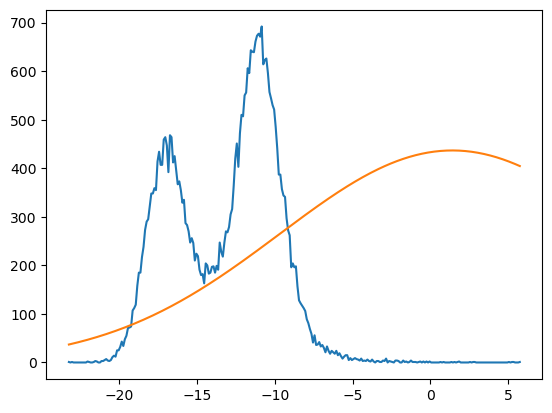

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fd8ae9304f0>

In [188]:
PyPlot.figure()
PyPlot.plot(y,w)
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )

In [231]:
p_fit,y,w = fit_bimodal_gauss(test_data,round(Int64,length(test_data)/100));

In [ ]:
import StatsBase;
using BenchmarkTools
import LsqFit
import Statistics

In [230]:


LsqFit.@. bimodal_gauss_model(x, p) = p[1]*exp(-0.5*((x-p[3])/p[5])^2) +  p[2]*exp(-0.5*((x-p[4])/p[6])^2)

function fit_bimodal_gauss(data,n_bins,maxIter=1000)
    h = StatsBase.fit(StatsBase.Histogram, data,nbins=n_bins)
    w = h.weights
    y = (collect(h.edges[1])[2:end] +  collect(h.edges[1])[1:end-1])/2;
    
    p0 = zeros(Float64,6)
    y_ot = Statistics.median(test_data)

    p0[3] = Statistics.mean(test_data[test_data.<y_ot])
    p0[5] = Statistics.std(test_data[test_data.<y_ot])
    p0[1] = w[findfirst(y.>p0[3])]


    p0[4] = Statistics.mean(test_data[test_data.>y_ot])
    p0[6] = Statistics.std(test_data[test_data.>y_ot])
    p0[2] = w[findfirst(y.>p0[4])];
    p_fit = LsqFit.curve_fit(bimodal_gauss_model, y, w, p0; autodiff=:forwarddiff,maxIter=1000).param
    
    return p_fit, y, w

end
    
    
    

fit_bimodal_gauss (generic function with 2 methods)

In [235]:
@benchmark p_fit,y,w = fit_bimodal_gauss(test_data,round(Int64,length(test_data)/100))

BenchmarkTools.Trial: 
  memory estimate:  1.49 MiB
  allocs estimate:  243
  --------------
  minimum time:     5.838 ms (0.00% GC)
  median time:      5.955 ms (0.00% GC)
  mean time:        5.973 ms (0.70% GC)
  maximum time:     11.515 ms (43.51% GC)
  --------------
  samples:          837
  evals/sample:     1

In [ ]:
p_fit,y,w = fit_bimodal_gauss(test_data,round(Int64,length(test_data)/100))

PyPlot.figure()
PyPlot.plot(y,w)
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )